# T1/T2 MRI CycleGAN s U-Net Generatorima

Ova bilježnica implementira CycleGAN model za transformaciju između T1 i T2 MRI snimaka. Koristi U-Net arhitekturu za generatore kako bi se postigli bolji rezultati u očuvanju strukture.

In [1]:
!nvidia-smi


Mon Jun 23 23:48:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   40C    P5             15W /   80W |     527MiB /   6144MiB |     32%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Postavljanje okruženja i uvoz bibliteka

In [2]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torch.backends.cudnn as cudnn
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
import datetime
import json

# Postavljanje random seed-a za reproducibilnost
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    # Omogućavanje CUDNN benchmarkinga za brže treniranje
    cudnn.benchmark = True
# Provjera dostupnosti GPU-a
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Koristim uređaj: {device}")
# Ako je dostupan CUDA, ispiši informacije o GPU-u
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memorija: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Koristim uređaj: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Memorija: 6.19 GB


In [3]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from utils.models import UNetGenerator
from utils.config import CycleGANConfig
from utils.dataset import get_stratified_data_loaders
from utils.train import train_cyclegan
from utils.test import test_model
from utils.visualization import visualize_results, plot_training_curves


In [4]:
config = CycleGANConfig(
    t1_dir="../dataset/data/images/t1",  # Prilagodite putanju prema vašim podacima
    t2_dir="../dataset/data/images/t2",  # Prilagodite putanju prema vašim podacima
    results_dir="../rezultati/standard_model_mse_b2",
    checkpoints_dir="../checkpoints/standard_model_mse_b2",
    batch_size=2,  # Smanjite za manje GPU memorije
    lr=0.0002,
    beta1=0.5,
    beta2=0.999,
    n_epochs=150,  # Prilagodite broj epoha prema potrebi
    decay_epoch=50,  # Learning rate počinje opadati nakon ove epohe
    img_size=256,
    input_channels=1,  # MRI slike su sive (1 kanal)
    output_channels=1,
    ngf=64,  # Broj filtera u generatoru
    ndf=64,  # Broj filtera u diskriminatoru
    lambda_A=10.0,  # Težina cycle loss-a za T1->T2->T1
    lambda_B=10.0,  # Težina cycle loss-a za T2->T1->T2
    lambda_identity=0.5,  # Težina identity loss-a
    architecture="standard",  # Koristimo standardnu arhitekturu
    sample_interval=10,  # Vizualiziraj slike svakih 5 epoha
    checkpoint_interval=50,  # Spremi checkpoint svakih 10 epoha
    device=None  # Automatski odabir (GPU ako je dostupan, inače CPU)
)

In [5]:
# Ispiši konfiguraciju
config.print_config()


=== Konfiguracija modela ===
Arhitektura: standard
T1 direktorij: ../dataset/data/images/t1
T2 direktorij: ../dataset/data/images/t2
Batch veličina: 2
Learning rate: 0.0002
Broj epoha: 150
Veličina slike: 256x256
Broj filtera u generatoru: 64
Broj filtera u diskriminatoru: 64
Lambda A: 10.0
Lambda B: 10.0
Lambda identity: 0.5
Uređaj: cuda



In [6]:
# Lista posebnih ID-ova za stratificiranu podjelu (ID-ovi "mutnijih" slika)
special_ids = [
    '035', '230', '231', '232', '233', '234', '238', '290', '291', '292', 
    '293', '294', '303', '305', '306', '307', '310', '314', '315', '322', 
    '331', '332', '333', '337', '340', '345', '347', '371', '372', '373', 
    '378', '382', '388', '395', '423', '424', '425', '426', '427', '430', 
    '433', '434', '435', '442', '462', '463', '464', '469', '470', '473', 
    '474', '475', '476', '477', '478', '510', '517', '532', '541', '542', 
    '543', '547', '548', '553', '561', '563', '571', '573', '574', '588', 
    '595', '596', '597'
]

print(f"Broj posebnih ID-ova: {len(special_ids)}")

train_dataloader, val_dataloader, test_dataloader = get_stratified_data_loaders(
    config=config,
    special_ids=special_ids,
    train_ratio=0.8,
    val_ratio=0.05,
    test_ratio=0.15
)

Broj posebnih ID-ova: 73
Pronađeno 572 T1 slika i 572 T2 slika
Pronađeno 572 sparenih T1/T2 slika
Pronađeno 69 posebnih slika i 503 regularnih slika.
Podjela posebnih slika: 55 trening, 3 validacija, 11 test
Podjela regularnih slika: 402 trening, 25 validacija, 76 test
Ukupna podjela: 457 trening, 28 validacija, 87 test


In [7]:
G_AB, G_BA, train_history, best_val_loss = train_cyclegan(
    config=config,
    use_test_split=True,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    discriminator_update_freq=1
)

Epoha 1/150: 100%|██████████| 229/229 [00:48<00:00,  4.75it/s, D_A=0.2440, D_B=0.2444, G=2.0209]


Epoha 1/150 - Train gubici: G: 5.6251, D_A: 0.3456, D_B: 0.3597 | Val gubici: G: 1.6554, Cycle: 1.1954
Novi najbolji validacijski cycle gubitak: 1.1954, spremam modele...
Novi najbolji validacijski GAN gubitak: 1.6554, spremam modele...


Epoha 2/150: 100%|██████████| 229/229 [00:45<00:00,  5.09it/s, D_A=0.2407, D_B=0.1811, G=1.7753]


Epoha 2/150 - Train gubici: G: 2.0318, D_A: 0.2519, D_B: 0.2352 | Val gubici: G: 1.7799, Cycle: 0.9132
Novi najbolji validacijski cycle gubitak: 0.9132, spremam modele...


Epoha 3/150: 100%|██████████| 229/229 [00:58<00:00,  3.94it/s, D_A=0.2234, D_B=0.3897, G=2.5689]


Epoha 3/150 - Train gubici: G: 1.8557, D_A: 0.2508, D_B: 0.2468 | Val gubici: G: 1.7181, Cycle: 0.9222


Epoha 4/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.2775, D_B=0.1814, G=1.6907]


Epoha 4/150 - Train gubici: G: 1.7532, D_A: 0.2499, D_B: 0.2411 | Val gubici: G: 1.3061, Cycle: 0.7564
Novi najbolji validacijski cycle gubitak: 0.7564, spremam modele...
Novi najbolji validacijski GAN gubitak: 1.3061, spremam modele...


Epoha 5/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.2317, D_B=0.3925, G=1.3626]


Epoha 5/150 - Train gubici: G: 1.6721, D_A: 0.2554, D_B: 0.2430 | Val gubici: G: 1.4565, Cycle: 0.8373


Epoha 6/150: 100%|██████████| 229/229 [01:29<00:00,  2.56it/s, D_A=0.1946, D_B=0.3318, G=1.4225]


Epoha 6/150 - Train gubici: G: 1.6072, D_A: 0.2559, D_B: 0.2361 | Val gubici: G: 1.3280, Cycle: 0.6646
Novi najbolji validacijski cycle gubitak: 0.6646, spremam modele...


Epoha 7/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2249, D_B=0.1834, G=1.2743]


Epoha 7/150 - Train gubici: G: 1.5762, D_A: 0.2507, D_B: 0.2382 | Val gubici: G: 1.2017, Cycle: 0.6752
Novi najbolji validacijski GAN gubitak: 1.2017, spremam modele...


Epoha 8/150: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A=0.2889, D_B=0.2319, G=1.5312]


Epoha 8/150 - Train gubici: G: 1.5065, D_A: 0.2498, D_B: 0.2381 | Val gubici: G: 1.3144, Cycle: 0.6805


Epoha 9/150: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A=0.1951, D_B=0.1045, G=1.3370]


Epoha 9/150 - Train gubici: G: 1.4828, D_A: 0.2541, D_B: 0.2407 | Val gubici: G: 1.3079, Cycle: 0.7186


Epoha 10/150: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A=0.2258, D_B=0.2827, G=1.6543]


Epoha 10/150 - Train gubici: G: 1.4561, D_A: 0.2578, D_B: 0.2332 | Val gubici: G: 1.3375, Cycle: 0.8363


Epoha 11/150: 100%|██████████| 229/229 [01:29<00:00,  2.56it/s, D_A=0.1797, D_B=0.1185, G=1.3557]


Epoha 11/150 - Train gubici: G: 1.4825, D_A: 0.2506, D_B: 0.2376 | Val gubici: G: 0.9443, Cycle: 0.6332
Novi najbolji validacijski cycle gubitak: 0.6332, spremam modele...
Novi najbolji validacijski GAN gubitak: 0.9443, spremam modele...


Epoha 12/150: 100%|██████████| 229/229 [01:28<00:00,  2.59it/s, D_A=0.2528, D_B=0.1073, G=1.2266]


Epoha 12/150 - Train gubici: G: 1.5040, D_A: 0.2911, D_B: 0.2257 | Val gubici: G: 0.9959, Cycle: 0.6155
Novi najbolji validacijski cycle gubitak: 0.6155, spremam modele...


Epoha 13/150: 100%|██████████| 229/229 [01:28<00:00,  2.57it/s, D_A=0.2498, D_B=0.2922, G=1.7157]


Epoha 13/150 - Train gubici: G: 1.3457, D_A: 0.2475, D_B: 0.2276 | Val gubici: G: 1.3099, Cycle: 0.6539


Epoha 14/150: 100%|██████████| 229/229 [01:29<00:00,  2.56it/s, D_A=0.2326, D_B=0.2248, G=1.5127]


Epoha 14/150 - Train gubici: G: 1.4092, D_A: 0.2548, D_B: 0.2198 | Val gubici: G: 1.2308, Cycle: 0.5852
Novi najbolji validacijski cycle gubitak: 0.5852, spremam modele...


Epoha 15/150: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A=0.1925, D_B=0.1411, G=1.0968]


Epoha 15/150 - Train gubici: G: 1.3848, D_A: 0.2580, D_B: 0.2211 | Val gubici: G: 1.2291, Cycle: 0.5904


Epoha 16/150: 100%|██████████| 229/229 [01:29<00:00,  2.56it/s, D_A=0.2437, D_B=0.2516, G=1.3616]


Epoha 16/150 - Train gubici: G: 1.4041, D_A: 0.2643, D_B: 0.2225 | Val gubici: G: 1.1365, Cycle: 0.5600
Novi najbolji validacijski cycle gubitak: 0.5600, spremam modele...


Epoha 17/150: 100%|██████████| 229/229 [01:26<00:00,  2.63it/s, D_A=0.2211, D_B=0.2924, G=1.1353]


Epoha 17/150 - Train gubici: G: 1.3623, D_A: 0.2541, D_B: 0.2166 | Val gubici: G: 1.6500, Cycle: 0.5762


Epoha 18/150: 100%|██████████| 229/229 [01:25<00:00,  2.69it/s, D_A=0.2248, D_B=0.2091, G=1.4417]


Epoha 18/150 - Train gubici: G: 1.3844, D_A: 0.2490, D_B: 0.2210 | Val gubici: G: 1.4831, Cycle: 0.6457


Epoha 19/150: 100%|██████████| 229/229 [01:24<00:00,  2.71it/s, D_A=0.2686, D_B=0.2732, G=1.2232]


Epoha 19/150 - Train gubici: G: 1.3987, D_A: 0.2563, D_B: 0.2130 | Val gubici: G: 1.3477, Cycle: 0.6659


Epoha 20/150: 100%|██████████| 229/229 [01:24<00:00,  2.71it/s, D_A=0.2290, D_B=0.2015, G=1.2723]


Epoha 20/150 - Train gubici: G: 1.3539, D_A: 0.2489, D_B: 0.2213 | Val gubici: G: 1.0461, Cycle: 0.6263


Epoha 21/150: 100%|██████████| 229/229 [01:24<00:00,  2.71it/s, D_A=0.1677, D_B=0.2405, G=1.8842]


Epoha 21/150 - Train gubici: G: 1.3665, D_A: 0.2460, D_B: 0.2116 | Val gubici: G: 1.5574, Cycle: 0.6106


Epoha 22/150: 100%|██████████| 229/229 [01:25<00:00,  2.67it/s, D_A=0.1470, D_B=0.2394, G=1.3476]


Epoha 22/150 - Train gubici: G: 1.3908, D_A: 0.2384, D_B: 0.2130 | Val gubici: G: 1.0315, Cycle: 0.5970


Epoha 23/150: 100%|██████████| 229/229 [01:24<00:00,  2.71it/s, D_A=0.2841, D_B=0.1240, G=1.7127]


Epoha 23/150 - Train gubici: G: 1.3696, D_A: 0.2515, D_B: 0.2103 | Val gubici: G: 1.0726, Cycle: 0.6552


Epoha 24/150: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A=0.1993, D_B=0.2596, G=1.4110]


Epoha 24/150 - Train gubici: G: 1.3547, D_A: 0.2375, D_B: 0.2145 | Val gubici: G: 2.1249, Cycle: 1.0362


Epoha 25/150: 100%|██████████| 229/229 [01:25<00:00,  2.66it/s, D_A=0.2428, D_B=0.1688, G=1.3463]


Epoha 25/150 - Train gubici: G: 1.3052, D_A: 0.2830, D_B: 0.2138 | Val gubici: G: 1.0031, Cycle: 0.6776


Epoha 26/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.2410, D_B=0.2109, G=1.3296]


Epoha 26/150 - Train gubici: G: 1.2331, D_A: 0.2469, D_B: 0.2096 | Val gubici: G: 1.1747, Cycle: 0.5937


Epoha 27/150: 100%|██████████| 229/229 [01:25<00:00,  2.68it/s, D_A=0.2974, D_B=0.2968, G=0.9121]


Epoha 27/150 - Train gubici: G: 1.3084, D_A: 0.2538, D_B: 0.2079 | Val gubici: G: 1.4441, Cycle: 0.5664


Epoha 28/150: 100%|██████████| 229/229 [01:24<00:00,  2.71it/s, D_A=0.1946, D_B=0.1126, G=0.9066]


Epoha 28/150 - Train gubici: G: 1.3025, D_A: 0.2465, D_B: 0.2082 | Val gubici: G: 0.9913, Cycle: 0.5461
Novi najbolji validacijski cycle gubitak: 0.5461, spremam modele...


Epoha 29/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.2347, D_B=0.1748, G=1.5624]


Epoha 29/150 - Train gubici: G: 1.2974, D_A: 0.2494, D_B: 0.2008 | Val gubici: G: 1.0724, Cycle: 0.5670


Epoha 30/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.3054, D_B=0.2758, G=1.0342]


Epoha 30/150 - Train gubici: G: 1.2659, D_A: 0.2441, D_B: 0.2118 | Val gubici: G: 1.5926, Cycle: 0.6513


Epoha 31/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.1271, D_B=0.1670, G=1.3230]


Epoha 31/150 - Train gubici: G: 1.2953, D_A: 0.2442, D_B: 0.2015 | Val gubici: G: 0.9470, Cycle: 0.5867


Epoha 32/150: 100%|██████████| 229/229 [01:25<00:00,  2.68it/s, D_A=0.2638, D_B=0.1149, G=1.9274]


Epoha 32/150 - Train gubici: G: 1.2987, D_A: 0.2453, D_B: 0.2007 | Val gubici: G: 1.2853, Cycle: 0.5614


Epoha 33/150: 100%|██████████| 229/229 [01:23<00:00,  2.76it/s, D_A=0.3834, D_B=0.2411, G=1.5960]


Epoha 33/150 - Train gubici: G: 1.2711, D_A: 0.2520, D_B: 0.2073 | Val gubici: G: 1.1293, Cycle: 0.6260


Epoha 34/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.3604, D_B=0.1035, G=0.8518]


Epoha 34/150 - Train gubici: G: 1.2867, D_A: 0.2413, D_B: 0.1985 | Val gubici: G: 1.2702, Cycle: 0.5751


Epoha 35/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.3276, D_B=0.1210, G=1.8373]


Epoha 35/150 - Train gubici: G: 1.2848, D_A: 0.2456, D_B: 0.2007 | Val gubici: G: 1.4428, Cycle: 0.8101


Epoha 36/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.2557, D_B=0.2392, G=1.0596]


Epoha 36/150 - Train gubici: G: 1.3177, D_A: 0.2432, D_B: 0.1942 | Val gubici: G: 1.7073, Cycle: 0.5450
Novi najbolji validacijski cycle gubitak: 0.5450, spremam modele...


Epoha 37/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.1844, D_B=0.1052, G=1.2139]


Epoha 37/150 - Train gubici: G: 1.2945, D_A: 0.2389, D_B: 0.1983 | Val gubici: G: 0.8516, Cycle: 0.5698
Novi najbolji validacijski GAN gubitak: 0.8516, spremam modele...


Epoha 38/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.2567, D_B=0.1485, G=1.1248]


Epoha 38/150 - Train gubici: G: 1.2766, D_A: 0.2467, D_B: 0.1940 | Val gubici: G: 1.1671, Cycle: 0.5651


Epoha 39/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.2050, D_B=0.2837, G=1.0451]


Epoha 39/150 - Train gubici: G: 1.2748, D_A: 0.2360, D_B: 0.1931 | Val gubici: G: 1.6128, Cycle: 0.5481


Epoha 40/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.1243, D_B=0.1132, G=1.7767]


Epoha 40/150 - Train gubici: G: 1.3266, D_A: 0.2442, D_B: 0.1850 | Val gubici: G: 1.2533, Cycle: 0.5677


Epoha 41/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.2628, D_B=0.1912, G=1.2886]


Epoha 41/150 - Train gubici: G: 1.3088, D_A: 0.2226, D_B: 0.1882 | Val gubici: G: 2.1418, Cycle: 0.5469


Epoha 42/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.2801, D_B=0.4131, G=1.3462]


Epoha 42/150 - Train gubici: G: 1.3290, D_A: 0.2284, D_B: 0.1908 | Val gubici: G: 1.4260, Cycle: 0.5411
Novi najbolji validacijski cycle gubitak: 0.5411, spremam modele...


Epoha 43/150: 100%|██████████| 229/229 [01:23<00:00,  2.75it/s, D_A=0.1735, D_B=0.1214, G=0.9770]


Epoha 43/150 - Train gubici: G: 1.2619, D_A: 0.2247, D_B: 0.1855 | Val gubici: G: 0.8395, Cycle: 0.5026
Novi najbolji validacijski cycle gubitak: 0.5026, spremam modele...
Novi najbolji validacijski GAN gubitak: 0.8395, spremam modele...


Epoha 44/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.3390, D_B=0.1173, G=0.9143]


Epoha 44/150 - Train gubici: G: 1.3459, D_A: 0.2228, D_B: 0.1767 | Val gubici: G: 1.2485, Cycle: 0.5111


Epoha 45/150: 100%|██████████| 229/229 [01:25<00:00,  2.68it/s, D_A=0.1741, D_B=0.0689, G=1.5470]


Epoha 45/150 - Train gubici: G: 1.3358, D_A: 0.2151, D_B: 0.1743 | Val gubici: G: 0.9929, Cycle: 0.5391


Epoha 46/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.2663, D_B=0.1356, G=1.2512]


Epoha 46/150 - Train gubici: G: 1.3826, D_A: 0.2168, D_B: 0.1763 | Val gubici: G: 1.3984, Cycle: 0.5531


Epoha 47/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.1434, D_B=0.0665, G=1.2418]


Epoha 47/150 - Train gubici: G: 1.3862, D_A: 0.2117, D_B: 0.1771 | Val gubici: G: 0.9475, Cycle: 0.5101


Epoha 48/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.1331, D_B=0.2210, G=1.6066]


Epoha 48/150 - Train gubici: G: 1.3592, D_A: 0.2057, D_B: 0.1741 | Val gubici: G: 0.9503, Cycle: 0.5201


Epoha 49/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.2026, D_B=0.0870, G=1.2360]


Epoha 49/150 - Train gubici: G: 1.3751, D_A: 0.1984, D_B: 0.1721 | Val gubici: G: 0.9397, Cycle: 0.5064


Epoha 50/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.3996, D_B=0.0658, G=1.2394]


Epoha 50/150 - Train gubici: G: 1.3530, D_A: 0.1969, D_B: 0.1732 | Val gubici: G: 1.6122, Cycle: 0.5177


Epoha 51/150: 100%|██████████| 229/229 [01:24<00:00,  2.73it/s, D_A=0.1093, D_B=0.1033, G=1.5228]


Epoha 51/150 - Train gubici: G: 1.3607, D_A: 0.2113, D_B: 0.1699 | Val gubici: G: 0.7461, Cycle: 0.4951
Novi najbolji validacijski cycle gubitak: 0.4951, spremam modele...
Novi najbolji validacijski GAN gubitak: 0.7461, spremam modele...


Epoha 52/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.2124, D_B=0.2237, G=1.3454]


Epoha 52/150 - Train gubici: G: 1.3258, D_A: 0.2031, D_B: 0.1640 | Val gubici: G: 1.2666, Cycle: 0.5062


Epoha 53/150: 100%|██████████| 229/229 [01:22<00:00,  2.77it/s, D_A=0.2162, D_B=0.1299, G=1.9355]


Epoha 53/150 - Train gubici: G: 1.3779, D_A: 0.1932, D_B: 0.1639 | Val gubici: G: 0.9472, Cycle: 0.4957


Epoha 54/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.5078, D_B=0.2261, G=2.4012]


Epoha 54/150 - Train gubici: G: 1.4201, D_A: 0.1945, D_B: 0.1599 | Val gubici: G: 0.9776, Cycle: 0.4945
Novi najbolji validacijski cycle gubitak: 0.4945, spremam modele...


Epoha 55/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.2335, D_B=0.0710, G=1.3802]


Epoha 55/150 - Train gubici: G: 1.3603, D_A: 0.1928, D_B: 0.1586 | Val gubici: G: 1.1935, Cycle: 0.5032


Epoha 56/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.2792, D_B=0.2519, G=1.2712]  


Epoha 56/150 - Train gubici: G: 2.4917, D_A: 0.1698, D_B: 1.0041 | Val gubici: G: 1.8406, Cycle: 0.7987


Epoha 57/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.1871, D_B=0.2547, G=1.6864]


Epoha 57/150 - Train gubici: G: 1.5677, D_A: 0.1836, D_B: 0.2495 | Val gubici: G: 1.2227, Cycle: 0.7154


Epoha 58/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.2385, D_B=0.2464, G=1.1065]


Epoha 58/150 - Train gubici: G: 1.3709, D_A: 0.1808, D_B: 0.2500 | Val gubici: G: 1.1644, Cycle: 0.5528


Epoha 59/150: 100%|██████████| 229/229 [01:25<00:00,  2.68it/s, D_A=0.1060, D_B=0.2500, G=1.2274]


Epoha 59/150 - Train gubici: G: 1.2804, D_A: 0.1858, D_B: 0.2501 | Val gubici: G: 1.0570, Cycle: 0.5673


Epoha 60/150: 100%|██████████| 229/229 [01:25<00:00,  2.67it/s, D_A=0.1961, D_B=0.2490, G=1.1421]


Epoha 60/150 - Train gubici: G: 1.2260, D_A: 0.1847, D_B: 0.2496 | Val gubici: G: 0.8727, Cycle: 0.4887
Novi najbolji validacijski cycle gubitak: 0.4887, spremam modele...


Epoha 61/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.1620, D_B=0.2426, G=1.4433]


Epoha 61/150 - Train gubici: G: 1.2234, D_A: 0.1797, D_B: 0.2496 | Val gubici: G: 1.2776, Cycle: 0.4553
Novi najbolji validacijski cycle gubitak: 0.4553, spremam modele...


Epoha 62/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.1009, D_B=0.2699, G=0.9828]


Epoha 62/150 - Train gubici: G: 1.1875, D_A: 0.1831, D_B: 0.2495 | Val gubici: G: 0.9253, Cycle: 0.4576


Epoha 63/150: 100%|██████████| 229/229 [01:24<00:00,  2.71it/s, D_A=0.2326, D_B=0.2549, G=0.9311]


Epoha 63/150 - Train gubici: G: 1.2007, D_A: 0.1709, D_B: 0.2499 | Val gubici: G: 1.8046, Cycle: 0.4336
Novi najbolji validacijski cycle gubitak: 0.4336, spremam modele...


Epoha 64/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.1183, D_B=0.2566, G=1.5805]


Epoha 64/150 - Train gubici: G: 1.2085, D_A: 0.1640, D_B: 0.2505 | Val gubici: G: 0.9937, Cycle: 0.4719


Epoha 65/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.3019, D_B=0.2612, G=0.8633]


Epoha 65/150 - Train gubici: G: 1.1703, D_A: 0.1706, D_B: 0.2525 | Val gubici: G: 1.7456, Cycle: 0.5150


Epoha 66/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0673, D_B=0.2656, G=1.0463]


Epoha 66/150 - Train gubici: G: 1.2078, D_A: 0.1601, D_B: 0.2581 | Val gubici: G: 0.8104, Cycle: 0.4281
Novi najbolji validacijski cycle gubitak: 0.4281, spremam modele...


Epoha 67/150: 100%|██████████| 229/229 [01:25<00:00,  2.67it/s, D_A=0.1601, D_B=0.2360, G=1.2573]


Epoha 67/150 - Train gubici: G: 1.1532, D_A: 0.1646, D_B: 0.2569 | Val gubici: G: 1.2000, Cycle: 0.4064
Novi najbolji validacijski cycle gubitak: 0.4064, spremam modele...


Epoha 68/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.2489, D_B=0.2580, G=1.5818]


Epoha 68/150 - Train gubici: G: 1.1541, D_A: 0.1744, D_B: 0.2581 | Val gubici: G: 0.9553, Cycle: 0.5111


Epoha 69/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.1122, D_B=0.2542, G=1.3487]


Epoha 69/150 - Train gubici: G: 1.1748, D_A: 0.1575, D_B: 0.2602 | Val gubici: G: 1.0426, Cycle: 0.3978
Novi najbolji validacijski cycle gubitak: 0.3978, spremam modele...


Epoha 70/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.2067, D_B=0.2530, G=1.5591]


Epoha 70/150 - Train gubici: G: 1.1722, D_A: 0.1619, D_B: 0.2590 | Val gubici: G: 0.8620, Cycle: 0.4645


Epoha 71/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.1529, D_B=0.2453, G=1.0782]


Epoha 71/150 - Train gubici: G: 1.1678, D_A: 0.1458, D_B: 0.2582 | Val gubici: G: 1.6981, Cycle: 0.4396


Epoha 72/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0938, D_B=0.2482, G=1.1719]


Epoha 72/150 - Train gubici: G: 1.1583, D_A: 0.1590, D_B: 0.2595 | Val gubici: G: 0.9335, Cycle: 0.4486


Epoha 73/150: 100%|██████████| 229/229 [01:23<00:00,  2.75it/s, D_A=0.1383, D_B=0.2610, G=1.2760]


Epoha 73/150 - Train gubici: G: 1.1828, D_A: 0.1525, D_B: 0.2572 | Val gubici: G: 1.5019, Cycle: 0.4028


Epoha 74/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.1953, D_B=0.2675, G=0.9992]


Epoha 74/150 - Train gubici: G: 1.1644, D_A: 0.1488, D_B: 0.2580 | Val gubici: G: 0.9241, Cycle: 0.3943
Novi najbolji validacijski cycle gubitak: 0.3943, spremam modele...


Epoha 75/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.1411, D_B=0.2375, G=1.0685]


Epoha 75/150 - Train gubici: G: 1.1855, D_A: 0.1509, D_B: 0.2550 | Val gubici: G: 1.1424, Cycle: 0.3948


Epoha 76/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.2923, D_B=0.2831, G=1.3089]


Epoha 76/150 - Train gubici: G: 1.1719, D_A: 0.1507, D_B: 0.2581 | Val gubici: G: 1.1660, Cycle: 0.4934


Epoha 77/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.2155, D_B=0.2709, G=1.3332]


Epoha 77/150 - Train gubici: G: 1.1514, D_A: 0.1462, D_B: 0.2572 | Val gubici: G: 1.3620, Cycle: 0.3951


Epoha 78/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.1229, D_B=0.2689, G=1.2849]


Epoha 78/150 - Train gubici: G: 1.1678, D_A: 0.1420, D_B: 0.2574 | Val gubici: G: 1.6035, Cycle: 0.4603


Epoha 79/150: 100%|██████████| 229/229 [01:25<00:00,  2.67it/s, D_A=0.1465, D_B=0.2573, G=1.2159]


Epoha 79/150 - Train gubici: G: 1.1873, D_A: 0.1472, D_B: 0.2553 | Val gubici: G: 0.9590, Cycle: 0.4103


Epoha 80/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.0810, D_B=0.2408, G=1.0423]


Epoha 80/150 - Train gubici: G: 1.1773, D_A: 0.1384, D_B: 0.2565 | Val gubici: G: 0.8662, Cycle: 0.4413


Epoha 81/150: 100%|██████████| 229/229 [01:24<00:00,  2.73it/s, D_A=0.1238, D_B=0.2565, G=1.0361]


Epoha 81/150 - Train gubici: G: 1.1880, D_A: 0.1373, D_B: 0.2550 | Val gubici: G: 1.2601, Cycle: 0.4093


Epoha 82/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.2058, D_B=0.2725, G=0.9471]


Epoha 82/150 - Train gubici: G: 1.1919, D_A: 0.1401, D_B: 0.2559 | Val gubici: G: 1.4908, Cycle: 0.3805
Novi najbolji validacijski cycle gubitak: 0.3805, spremam modele...


Epoha 83/150: 100%|██████████| 229/229 [01:23<00:00,  2.75it/s, D_A=0.1276, D_B=0.2435, G=1.5735]


Epoha 83/150 - Train gubici: G: 1.2064, D_A: 0.1298, D_B: 0.2556 | Val gubici: G: 1.2962, Cycle: 0.3915


Epoha 84/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.0859, D_B=0.2670, G=1.5732]


Epoha 84/150 - Train gubici: G: 1.2228, D_A: 0.1241, D_B: 0.2527 | Val gubici: G: 0.7205, Cycle: 0.4003
Novi najbolji validacijski GAN gubitak: 0.7205, spremam modele...


Epoha 85/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.1037, D_B=0.2531, G=1.2274]


Epoha 85/150 - Train gubici: G: 1.1915, D_A: 0.1315, D_B: 0.2558 | Val gubici: G: 1.2845, Cycle: 0.4229


Epoha 86/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.1762, D_B=0.3048, G=1.0545]


Epoha 86/150 - Train gubici: G: 1.2130, D_A: 0.1328, D_B: 0.2532 | Val gubici: G: 1.3802, Cycle: 0.3836


Epoha 87/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.1022, D_B=0.2604, G=1.1517]


Epoha 87/150 - Train gubici: G: 1.1772, D_A: 0.1340, D_B: 0.2533 | Val gubici: G: 0.8537, Cycle: 0.3710
Novi najbolji validacijski cycle gubitak: 0.3710, spremam modele...


Epoha 88/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.1319, D_B=0.2509, G=1.5190]


Epoha 88/150 - Train gubici: G: 1.1932, D_A: 0.1274, D_B: 0.2543 | Val gubici: G: 1.5619, Cycle: 0.3814


Epoha 89/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.1019, D_B=0.2598, G=0.8031]


Epoha 89/150 - Train gubici: G: 1.2115, D_A: 0.1158, D_B: 0.2554 | Val gubici: G: 1.2336, Cycle: 0.3868


Epoha 90/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.0522, D_B=0.2215, G=1.1857]


Epoha 90/150 - Train gubici: G: 1.2005, D_A: 0.1249, D_B: 0.2515 | Val gubici: G: 1.0741, Cycle: 0.4101


Epoha 91/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.2084, D_B=0.2460, G=0.9060]


Epoha 91/150 - Train gubici: G: 1.2305, D_A: 0.1226, D_B: 0.2526 | Val gubici: G: 1.4483, Cycle: 0.3970


Epoha 92/150: 100%|██████████| 229/229 [01:24<00:00,  2.73it/s, D_A=0.0437, D_B=0.2403, G=0.9625]


Epoha 92/150 - Train gubici: G: 1.2467, D_A: 0.1196, D_B: 0.2526 | Val gubici: G: 0.8774, Cycle: 0.4005


Epoha 93/150: 100%|██████████| 229/229 [01:24<00:00,  2.71it/s, D_A=0.0892, D_B=0.2493, G=1.2168]


Epoha 93/150 - Train gubici: G: 1.2303, D_A: 0.1102, D_B: 0.2519 | Val gubici: G: 1.0249, Cycle: 0.4269


Epoha 94/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.1117, D_B=0.2698, G=1.1898]


Epoha 94/150 - Train gubici: G: 1.2365, D_A: 0.1189, D_B: 0.2494 | Val gubici: G: 1.2202, Cycle: 0.3793


Epoha 95/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.1067, D_B=0.2635, G=1.3616]


Epoha 95/150 - Train gubici: G: 1.2272, D_A: 0.1146, D_B: 0.2530 | Val gubici: G: 1.1181, Cycle: 0.4073


Epoha 96/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0680, D_B=0.2574, G=1.6574]


Epoha 96/150 - Train gubici: G: 1.2306, D_A: 0.1101, D_B: 0.2515 | Val gubici: G: 1.2097, Cycle: 0.4098


Epoha 97/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.1823, D_B=0.2310, G=1.5370]


Epoha 97/150 - Train gubici: G: 1.2596, D_A: 0.1069, D_B: 0.2536 | Val gubici: G: 1.0567, Cycle: 0.3946


Epoha 98/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.2284, D_B=0.2580, G=1.3416]


Epoha 98/150 - Train gubici: G: 1.2382, D_A: 0.1066, D_B: 0.2536 | Val gubici: G: 0.8392, Cycle: 0.3810


Epoha 99/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.1736, D_B=0.2437, G=1.0817]


Epoha 99/150 - Train gubici: G: 1.2226, D_A: 0.1086, D_B: 0.2496 | Val gubici: G: 1.3075, Cycle: 0.3906


Epoha 100/150: 100%|██████████| 229/229 [01:24<00:00,  2.73it/s, D_A=0.1600, D_B=0.2246, G=1.6894]


Epoha 100/150 - Train gubici: G: 1.2404, D_A: 0.1115, D_B: 0.2501 | Val gubici: G: 1.7389, Cycle: 0.3948


Epoha 101/150: 100%|██████████| 229/229 [01:24<00:00,  2.71it/s, D_A=0.0698, D_B=0.2429, G=1.5486]


Epoha 101/150 - Train gubici: G: 1.2814, D_A: 0.1003, D_B: 0.2511 | Val gubici: G: 1.1218, Cycle: 0.3919


Epoha 102/150: 100%|██████████| 229/229 [01:24<00:00,  2.71it/s, D_A=0.0929, D_B=0.2336, G=1.5773]


Epoha 102/150 - Train gubici: G: 1.2930, D_A: 0.0935, D_B: 0.2483 | Val gubici: G: 1.9826, Cycle: 0.3973


Epoha 103/150: 100%|██████████| 229/229 [01:23<00:00,  2.75it/s, D_A=0.1065, D_B=0.2882, G=1.2057]


Epoha 103/150 - Train gubici: G: 1.2879, D_A: 0.0922, D_B: 0.2496 | Val gubici: G: 1.5478, Cycle: 0.3949


Epoha 104/150: 100%|██████████| 229/229 [01:24<00:00,  2.73it/s, D_A=0.1163, D_B=0.2384, G=1.2829]


Epoha 104/150 - Train gubici: G: 1.2977, D_A: 0.0982, D_B: 0.2498 | Val gubici: G: 1.6939, Cycle: 0.3950


Epoha 105/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.0842, D_B=0.2379, G=1.3257]


Epoha 105/150 - Train gubici: G: 1.3066, D_A: 0.0944, D_B: 0.2476 | Val gubici: G: 1.3373, Cycle: 0.3882


Epoha 106/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.1293, D_B=0.2492, G=1.0470]


Epoha 106/150 - Train gubici: G: 1.2780, D_A: 0.0944, D_B: 0.2479 | Val gubici: G: 1.4819, Cycle: 0.4102


Epoha 107/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.1111, D_B=0.2583, G=1.5451]


Epoha 107/150 - Train gubici: G: 1.2915, D_A: 0.0988, D_B: 0.2465 | Val gubici: G: 1.3349, Cycle: 0.3999


Epoha 108/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.1274, D_B=0.2260, G=1.1806]


Epoha 108/150 - Train gubici: G: 1.2500, D_A: 0.0967, D_B: 0.2480 | Val gubici: G: 1.7437, Cycle: 0.4068


Epoha 109/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.0852, D_B=0.2448, G=1.3700]


Epoha 109/150 - Train gubici: G: 1.3051, D_A: 0.0909, D_B: 0.2503 | Val gubici: G: 1.3375, Cycle: 0.3831


Epoha 110/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.1040, D_B=0.2849, G=1.2095]


Epoha 110/150 - Train gubici: G: 1.3018, D_A: 0.0902, D_B: 0.2435 | Val gubici: G: 1.2217, Cycle: 0.4086


Epoha 111/150: 100%|██████████| 229/229 [01:24<00:00,  2.71it/s, D_A=0.0796, D_B=0.2202, G=1.5801]


Epoha 111/150 - Train gubici: G: 1.3337, D_A: 0.0876, D_B: 0.2376 | Val gubici: G: 1.4374, Cycle: 0.4007


Epoha 112/150: 100%|██████████| 229/229 [01:24<00:00,  2.71it/s, D_A=0.0677, D_B=0.2413, G=1.4089]


Epoha 112/150 - Train gubici: G: 1.3669, D_A: 0.0835, D_B: 0.2507 | Val gubici: G: 1.3934, Cycle: 0.3875


Epoha 113/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.0726, D_B=0.2443, G=1.4996]


Epoha 113/150 - Train gubici: G: 1.3002, D_A: 0.0851, D_B: 0.2482 | Val gubici: G: 1.5611, Cycle: 0.3953


Epoha 114/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.1258, D_B=0.2534, G=1.2237]


Epoha 114/150 - Train gubici: G: 1.3284, D_A: 0.0793, D_B: 0.2483 | Val gubici: G: 1.3962, Cycle: 0.3892


Epoha 115/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.0803, D_B=0.2487, G=1.3380]


Epoha 115/150 - Train gubici: G: 1.3096, D_A: 0.0823, D_B: 0.2479 | Val gubici: G: 1.4083, Cycle: 0.4065


Epoha 116/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.0332, D_B=0.2445, G=1.1143]


Epoha 116/150 - Train gubici: G: 1.3177, D_A: 0.0784, D_B: 0.2472 | Val gubici: G: 1.4077, Cycle: 0.3871


Epoha 117/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.0820, D_B=0.2554, G=1.2360]


Epoha 117/150 - Train gubici: G: 1.3342, D_A: 0.0811, D_B: 0.2537 | Val gubici: G: 1.4260, Cycle: 0.3886


Epoha 118/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.0463, D_B=0.2259, G=1.0818]


Epoha 118/150 - Train gubici: G: 1.3144, D_A: 0.0763, D_B: 0.2477 | Val gubici: G: 1.3811, Cycle: 0.3886


Epoha 119/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.0786, D_B=0.2178, G=1.1463]


Epoha 119/150 - Train gubici: G: 1.3252, D_A: 0.0739, D_B: 0.2491 | Val gubici: G: 1.6985, Cycle: 0.3883


Epoha 120/150: 100%|██████████| 229/229 [01:24<00:00,  2.73it/s, D_A=0.0944, D_B=0.2455, G=1.2330]


Epoha 120/150 - Train gubici: G: 1.3343, D_A: 0.0727, D_B: 0.2472 | Val gubici: G: 1.7365, Cycle: 0.3866


Epoha 121/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0385, D_B=0.2347, G=1.6606]


Epoha 121/150 - Train gubici: G: 1.3331, D_A: 0.0738, D_B: 0.2456 | Val gubici: G: 1.2769, Cycle: 0.3879


Epoha 122/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0494, D_B=0.2422, G=1.1146]


Epoha 122/150 - Train gubici: G: 1.3400, D_A: 0.0721, D_B: 0.2482 | Val gubici: G: 1.4424, Cycle: 0.3826


Epoha 123/150: 100%|██████████| 229/229 [01:23<00:00,  2.75it/s, D_A=0.0796, D_B=0.2706, G=1.4232]


Epoha 123/150 - Train gubici: G: 1.3827, D_A: 0.0662, D_B: 0.2472 | Val gubici: G: 1.6688, Cycle: 0.4016


Epoha 124/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0652, D_B=0.2306, G=1.4033]


Epoha 124/150 - Train gubici: G: 1.3937, D_A: 0.0657, D_B: 0.2465 | Val gubici: G: 1.6788, Cycle: 0.3885


Epoha 125/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0720, D_B=0.2385, G=1.5727]


Epoha 125/150 - Train gubici: G: 1.3455, D_A: 0.0677, D_B: 0.2435 | Val gubici: G: 1.6039, Cycle: 0.3900


Epoha 126/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0659, D_B=0.2390, G=1.3288]


Epoha 126/150 - Train gubici: G: 1.3412, D_A: 0.0669, D_B: 0.2455 | Val gubici: G: 1.7094, Cycle: 0.3931


Epoha 127/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0488, D_B=0.2617, G=1.4101]


Epoha 127/150 - Train gubici: G: 1.3902, D_A: 0.0611, D_B: 0.2460 | Val gubici: G: 1.7041, Cycle: 0.3979


Epoha 128/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0694, D_B=0.2972, G=1.2711]


Epoha 128/150 - Train gubici: G: 1.3675, D_A: 0.0636, D_B: 0.2436 | Val gubici: G: 1.8164, Cycle: 0.3990


Epoha 129/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0470, D_B=0.2527, G=1.5112]


Epoha 129/150 - Train gubici: G: 1.3840, D_A: 0.0601, D_B: 0.2442 | Val gubici: G: 1.7355, Cycle: 0.3920


Epoha 130/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.0705, D_B=0.2679, G=1.1387]


Epoha 130/150 - Train gubici: G: 1.4105, D_A: 0.0546, D_B: 0.2450 | Val gubici: G: 1.7443, Cycle: 0.3931


Epoha 131/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.0293, D_B=0.2237, G=1.4714]


Epoha 131/150 - Train gubici: G: 1.3947, D_A: 0.0559, D_B: 0.2436 | Val gubici: G: 1.6814, Cycle: 0.3945


Epoha 132/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.1273, D_B=0.2245, G=1.6121]


Epoha 132/150 - Train gubici: G: 1.4124, D_A: 0.0549, D_B: 0.2413 | Val gubici: G: 1.2297, Cycle: 0.4037


Epoha 133/150: 100%|██████████| 229/229 [01:23<00:00,  2.75it/s, D_A=0.0389, D_B=0.2479, G=1.6389]


Epoha 133/150 - Train gubici: G: 1.3909, D_A: 0.0541, D_B: 0.2425 | Val gubici: G: 2.0825, Cycle: 0.3984


Epoha 134/150: 100%|██████████| 229/229 [01:24<00:00,  2.73it/s, D_A=0.0467, D_B=0.2553, G=1.3829]


Epoha 134/150 - Train gubici: G: 1.4070, D_A: 0.0518, D_B: 0.2419 | Val gubici: G: 1.9740, Cycle: 0.4054


Epoha 135/150: 100%|██████████| 229/229 [01:24<00:00,  2.73it/s, D_A=0.0696, D_B=0.2730, G=1.3997]


Epoha 135/150 - Train gubici: G: 1.4157, D_A: 0.0503, D_B: 0.2445 | Val gubici: G: 1.8899, Cycle: 0.3975


Epoha 136/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.0552, D_B=0.2302, G=1.5652]


Epoha 136/150 - Train gubici: G: 1.4227, D_A: 0.0496, D_B: 0.2441 | Val gubici: G: 1.9892, Cycle: 0.3947


Epoha 137/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.0303, D_B=0.2415, G=1.5795]


Epoha 137/150 - Train gubici: G: 1.4421, D_A: 0.0470, D_B: 0.2431 | Val gubici: G: 2.0197, Cycle: 0.4008


Epoha 138/150: 100%|██████████| 229/229 [01:24<00:00,  2.73it/s, D_A=0.0402, D_B=0.2584, G=1.4190]


Epoha 138/150 - Train gubici: G: 1.4236, D_A: 0.0465, D_B: 0.2427 | Val gubici: G: 1.9369, Cycle: 0.3931


Epoha 139/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.0391, D_B=0.2324, G=1.6473]


Epoha 139/150 - Train gubici: G: 1.4184, D_A: 0.0466, D_B: 0.2416 | Val gubici: G: 1.8746, Cycle: 0.4021


Epoha 140/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0445, D_B=0.2381, G=1.5640]


Epoha 140/150 - Train gubici: G: 1.4256, D_A: 0.0443, D_B: 0.2410 | Val gubici: G: 1.9005, Cycle: 0.4105


Epoha 141/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.0401, D_B=0.2583, G=1.4214]


Epoha 141/150 - Train gubici: G: 1.4507, D_A: 0.0420, D_B: 0.2403 | Val gubici: G: 2.0036, Cycle: 0.4004


Epoha 142/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.0323, D_B=0.2216, G=1.3855]


Epoha 142/150 - Train gubici: G: 1.4460, D_A: 0.0414, D_B: 0.2401 | Val gubici: G: 2.0681, Cycle: 0.4068


Epoha 143/150: 100%|██████████| 229/229 [01:24<00:00,  2.70it/s, D_A=0.0527, D_B=0.2522, G=1.3212]


Epoha 143/150 - Train gubici: G: 1.4560, D_A: 0.0395, D_B: 0.2398 | Val gubici: G: 2.0755, Cycle: 0.4026


Epoha 144/150: 100%|██████████| 229/229 [01:27<00:00,  2.63it/s, D_A=0.0396, D_B=0.2458, G=1.3746]


Epoha 144/150 - Train gubici: G: 1.4605, D_A: 0.0387, D_B: 0.2387 | Val gubici: G: 1.9781, Cycle: 0.4037


Epoha 145/150: 100%|██████████| 229/229 [01:26<00:00,  2.64it/s, D_A=0.0390, D_B=0.2610, G=1.4214]


Epoha 145/150 - Train gubici: G: 1.4643, D_A: 0.0385, D_B: 0.2387 | Val gubici: G: 1.9699, Cycle: 0.3970


Epoha 146/150: 100%|██████████| 229/229 [01:24<00:00,  2.71it/s, D_A=0.0310, D_B=0.2267, G=1.3300]


Epoha 146/150 - Train gubici: G: 1.4708, D_A: 0.0363, D_B: 0.2377 | Val gubici: G: 2.0312, Cycle: 0.3993


Epoha 147/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0382, D_B=0.2735, G=1.3563]


Epoha 147/150 - Train gubici: G: 1.4802, D_A: 0.0349, D_B: 0.2382 | Val gubici: G: 2.1416, Cycle: 0.4018


Epoha 148/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.0303, D_B=0.2541, G=1.3735]


Epoha 148/150 - Train gubici: G: 1.4804, D_A: 0.0346, D_B: 0.2361 | Val gubici: G: 2.0900, Cycle: 0.4007


Epoha 149/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0384, D_B=0.2446, G=1.4065]


Epoha 149/150 - Train gubici: G: 1.4904, D_A: 0.0329, D_B: 0.2366 | Val gubici: G: 2.1182, Cycle: 0.4004


Epoha 150/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.0311, D_B=0.2170, G=1.6335]


Epoha 150/150 - Train gubici: G: 1.4899, D_A: 0.0326, D_B: 0.2363 | Val gubici: G: 2.1007, Cycle: 0.4006

Evaluiram model na test setu...


Evaluacija modela: 100%|██████████| 44/44 [00:03<00:00, 11.77it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.8394
  MSE: 0.003609
  PSNR: 24.74 dB

T2 -> T1 translacija:
  SSIM: 0.8671
  MSE: 0.003346
  PSNR: 25.03 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9740
  MSE: 0.000471
  PSNR: 33.54 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9506
  MSE: 0.000752
  PSNR: 31.45 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.7472
  MSE: 0.005962
  PSNR: 22.56 dB

T2 -> T1 translacija:
  SSIM: 0.7854
  MSE: 0.005527
  PSNR: 22.85 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9568
  MSE: 0.000778
  PSNR: 31.36 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9175
  MSE: 0.001243
  PSNR: 29.27 dB


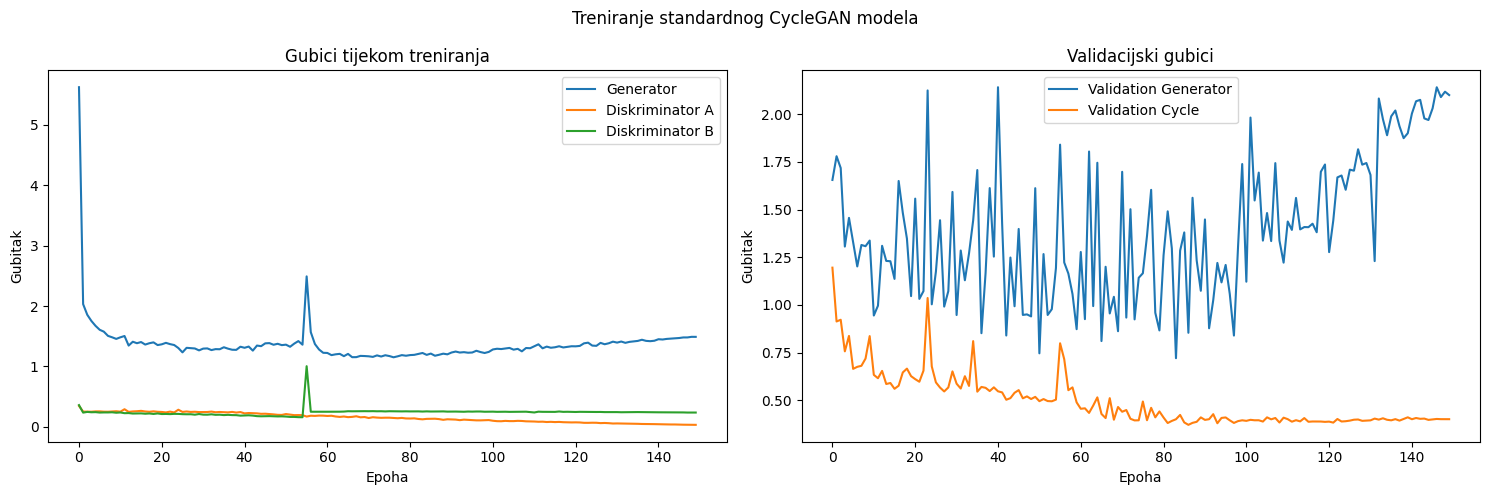

In [8]:
# Vizualizacija krivulja treniranja
plot_training_curves(train_history, "Treniranje standardnog CycleGAN modela")

In [9]:
test_model(G_AB=G_AB, G_BA=G_BA, test_dataloader=test_dataloader, config=config)

Evaluacija modela: 100%|██████████| 44/44 [00:03<00:00, 11.46it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.8394
  MSE: 0.003609
  PSNR: 24.74 dB

T2 -> T1 translacija:
  SSIM: 0.8671
  MSE: 0.003346
  PSNR: 25.03 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9740
  MSE: 0.000471
  PSNR: 33.54 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9506
  MSE: 0.000752
  PSNR: 31.45 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.7472
  MSE: 0.005962
  PSNR: 22.56 dB

T2 -> T1 translacija:
  SSIM: 0.7854
  MSE: 0.005527
  PSNR: 22.85 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9568
  MSE: 0.000778
  PSNR: 31.36 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9175
  MSE: 0.001243
  PSNR: 29.27 dB


Vizualizacija rezultata na test setu:


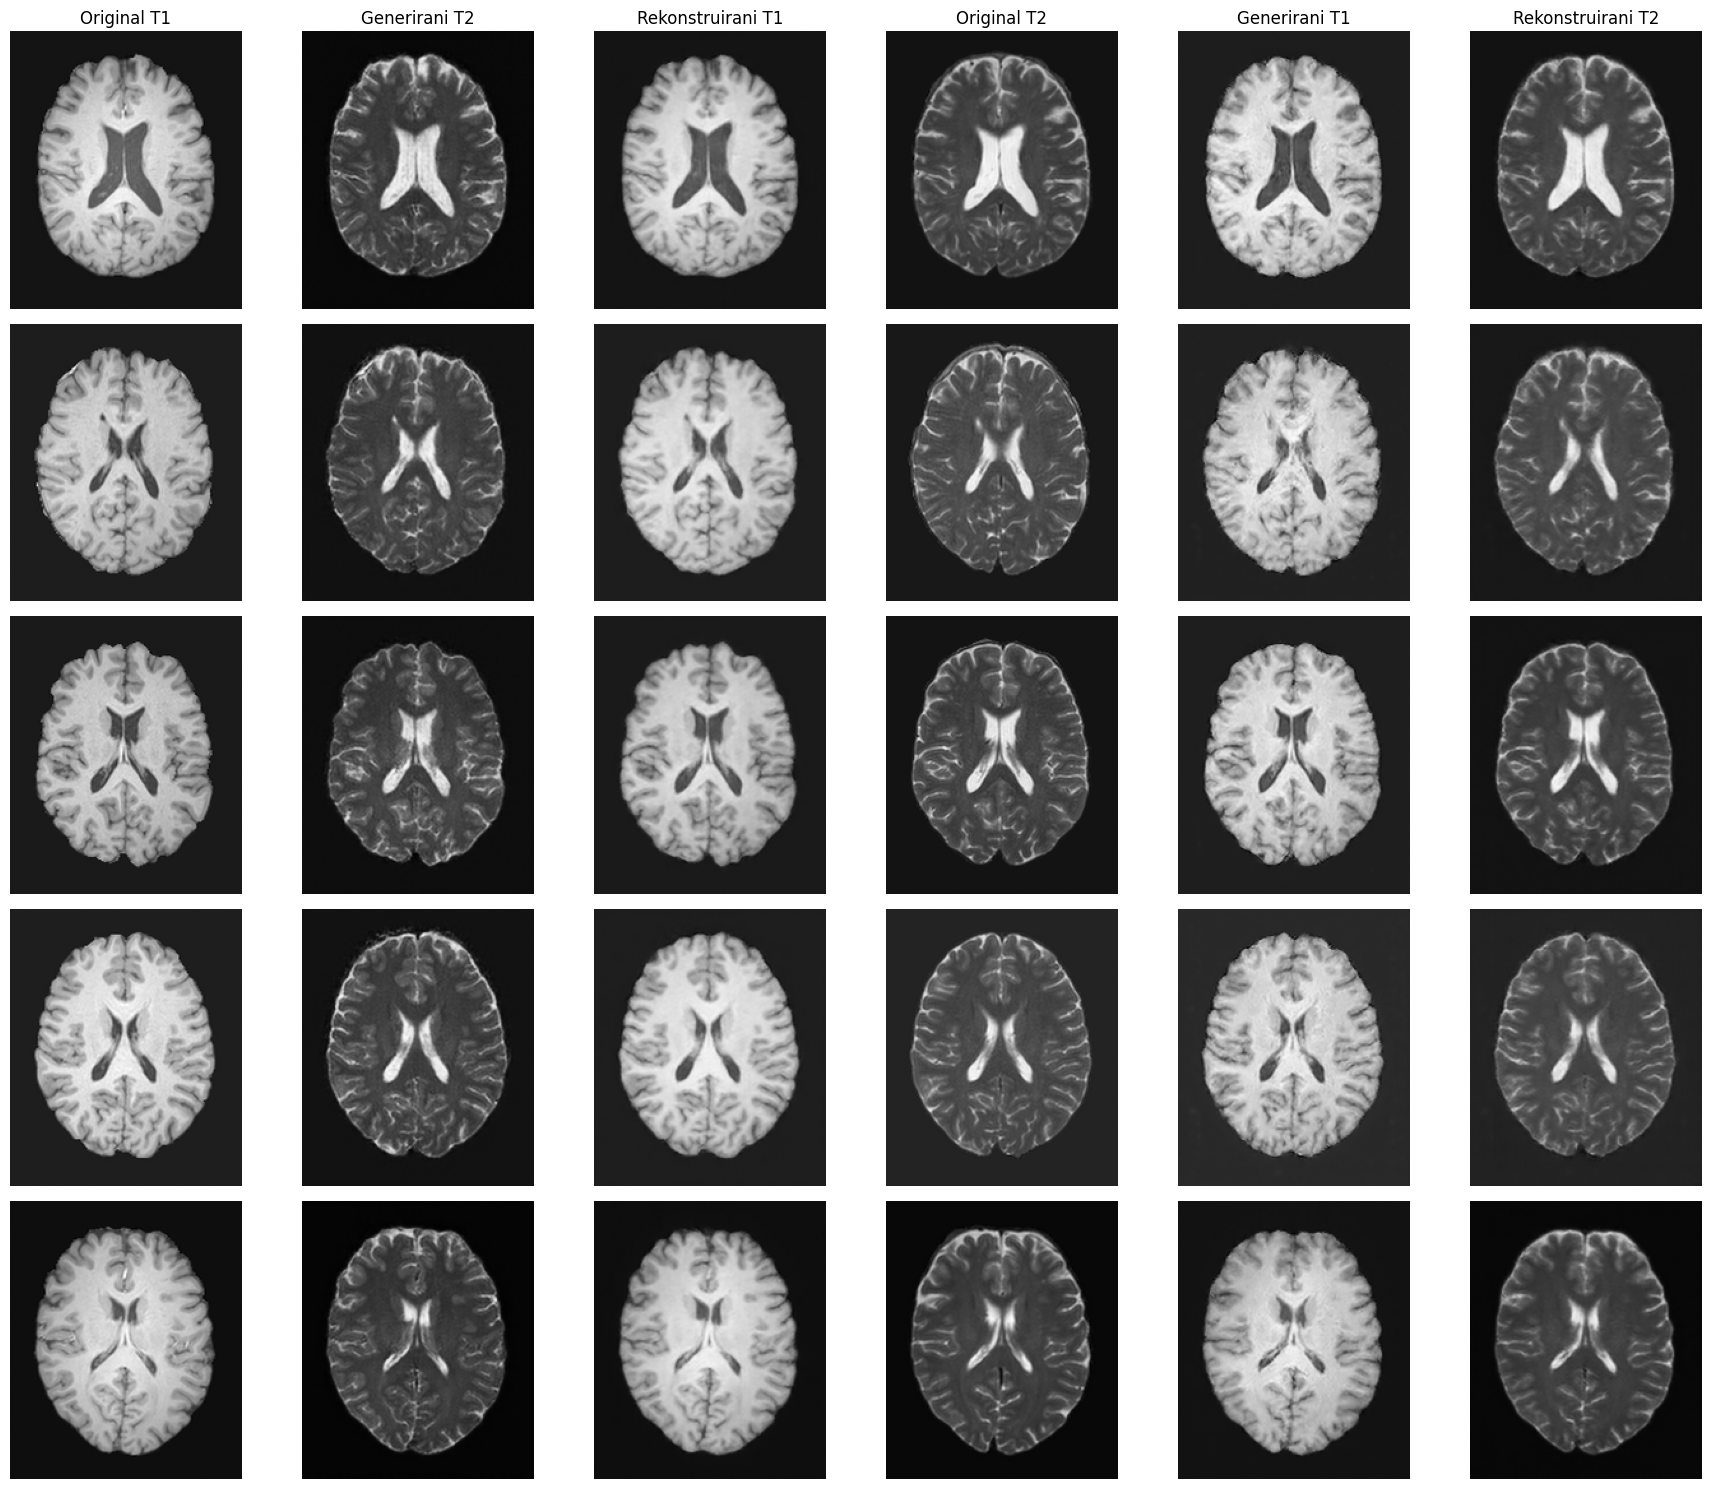

In [10]:
print("Vizualizacija rezultata na test setu:")
visualize_results(G_AB, G_BA, test_dataloader, num_samples=5, config=config)

In [13]:
best_G_AB_cycle = UNetGenerator(config.input_channels, config.output_channels, config.ngf).to(config.device)
best_G_BA_cycle = UNetGenerator(config.input_channels, config.output_channels, config.ngf).to(config.device)

# Putanje do najboljih modela
best_G_AB_path_cycle = f"{config.checkpoints_dir}/G_AB_cycle_best.pth"
best_G_BA_path_cycle = f"{config.checkpoints_dir}/G_BA_cycle_best.pth"
best_G_AB_cycle.load_state_dict(torch.load(best_G_AB_path_cycle, map_location=config.device))
best_G_BA_cycle.load_state_dict(torch.load(best_G_BA_path_cycle, map_location=config.device))

<All keys matched successfully>

In [14]:
print("Testiranje najboljih cyclce modela:")
test_model(best_G_AB_cycle, best_G_BA_cycle, test_dataloader, config)

Testiranje najboljih cyclce modela:


Evaluacija modela: 100%|██████████| 44/44 [00:03<00:00, 11.05it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.8400
  MSE: 0.003611
  PSNR: 24.70 dB

T2 -> T1 translacija:
  SSIM: 0.8653
  MSE: 0.003341
  PSNR: 25.06 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9799
  MSE: 0.000360
  PSNR: 34.78 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9577
  MSE: 0.000660
  PSNR: 31.93 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.7483
  MSE: 0.005965
  PSNR: 22.52 dB

T2 -> T1 translacija:
  SSIM: 0.7812
  MSE: 0.005519
  PSNR: 22.88 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9666
  MSE: 0.000595
  PSNR: 32.60 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9293
  MSE: 0.001089
  PSNR: 29.75 dB


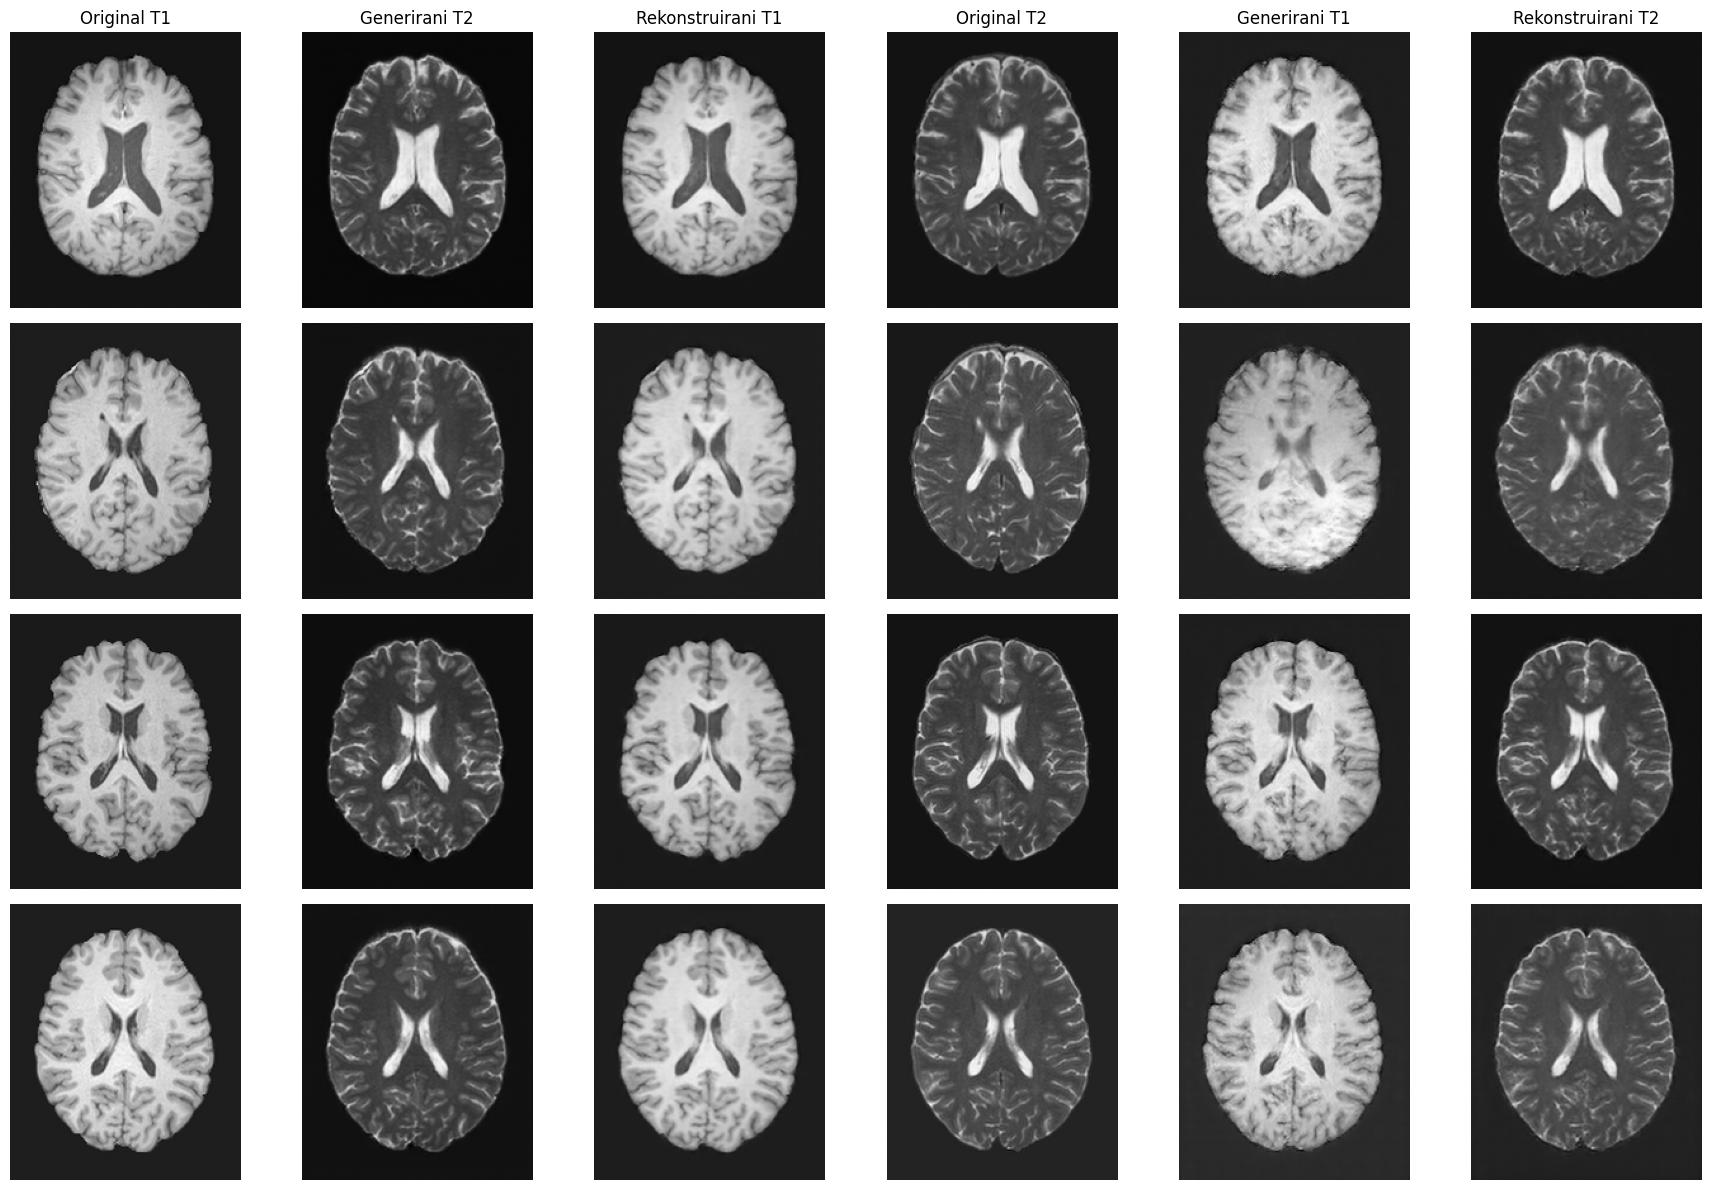

In [15]:
visualize_results(
    best_G_AB_cycle, best_G_BA_cycle, test_dataloader, num_samples=4, config=config
)

In [ ]:
best_G_AB_gan = UNetGenerator(config.input_channels, config.output_channels, config.ngf).to(config.device)
best_G_BA_gan = UNetGenerator(config.input_channels, config.output_channels, config.ngf).to(config.device)

# Putanje do najboljih modela
best_G_AB_path_gan = f"{config.checkpoints_dir}/G_AB_gan_best.pth"
best_G_BA_path_gan = f"{config.checkpoints_dir}/G_BA_gan_best.pth"
best_G_AB_gan.load_state_dict(torch.load(best_G_AB_path_gan, map_location=config.device))
best_G_BA_gan.load_state_dict(torch.load(best_G_BA_path_gan, map_location=config.device))

<All keys matched successfully>

In [ ]:
print("Testiranje najboljih cyclce modela:")
test_model(best_G_AB_gan, best_G_BA_gan, test_dataloader, config)

Testiranje najboljih cyclce modela:


Evaluacija modela: 100%|██████████| 22/22 [00:02<00:00,  8.72it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.7809
  MSE: 0.007103
  PSNR: 21.87 dB

T2 -> T1 translacija:
  SSIM: 0.8022
  MSE: 0.005916
  PSNR: 22.52 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9430
  MSE: 0.000874
  PSNR: 30.75 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9288
  MSE: 0.001813
  PSNR: 27.71 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.6510
  MSE: 0.011732
  PSNR: 19.69 dB

T2 -> T1 translacija:
  SSIM: 0.6791
  MSE: 0.009772
  PSNR: 20.34 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9050
  MSE: 0.001443
  PSNR: 28.58 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8819
  MSE: 0.002995
  PSNR: 25.53 dB
